# Stage: data collection and importing
## Import the Linkedin postings 2023-24 from Hugging face.

Data is collected by the creator using web-scraping.

This notebook imports the dataset to databricks, saves it as delta data in spark, which is then able to perform SQL queries.

In [0]:
# install the package which allow to connect to hugging face
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 163.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 120.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 15.0.2
    Not uninstalling pyarrow at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-7f53ae95-35b5-443c-bb07-b620053b8843
    Can't uninstall 'pyarrow'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# import all the packages
from datasets import load_dataset
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns



In [0]:
# Load the dataset by its Hugging Face identifier
df1 = load_dataset("lof223/linkedinjobs")
df2 = load_dataset("lof223/job_description")

In [0]:
# Convert the 'train' split to a Pandas DataFrame
df1_pandas = df1['train'].to_pandas()
df2_pandas = df2['train'].to_pandas()


# Convert Pandas DataFrame to Spark DataFrame
df1_spark = spark.createDataFrame(df1_pandas)
#df2_spark = spark.createDataFrame(df2_pandas) #my server is limited to load this so do the data cleaning first before saving to my catalog

# Save df1 directly
df1_spark.write.format("delta").saveAsTable(
    "my_catalog.linkedin_postings_2023_25.2023_24dtable"
)



Extract the year data and compare the years covered in both dataset.
df1 covers 2023-24, df2 covers 2021-2023


In [0]:

df2_pandas.head(3)
df2_pandas["year"] = df2_pandas["Job Posting Date"].str[:4]
print(df2_pandas[["Job Posting Date", "year"]].head())

# check the number of years in df2
year_count = df2_pandas.groupby(df2_pandas["year"]).size()
print(year_count)
# only 2023 is covered in both, while df1 is the main dataset, for df2 we only want to keep the rows with year 2023.


Job Posting Date year 2022-04-24 2022 2022-12-19 2022 2022-09-14 2022 2023-02-25 2023 2022-10-11 2022

Now we want to select only the relevant columns to save the data in the catalog.

In [0]:
df2_pandas.head(1)

Job Id  ...  year
0  1089843540111562  ...  2022

[1 rows x 24 columns]

In [0]:
# the dataset is too large for my server to be save it in the catalogue
# keep only the relevant columns
df2_sub = df2_pandas[
    [
        "Job Title",
        "Company Size",
        'year',
        'Experience'
        ] ]


# Rename column names to be able to save in spark
df2_sub.columns = [
    c.replace(" ", "_").replace("-", "_") for c in df2_sub.columns
]

df2_sub.head(5)

Job_Title  Company_Size  year     Experience
0  Digital Marketing Specialist         26801  2022  5 to 15 Years
1                 Web Developer        100340  2022  2 to 12 Years
2            Operations Manager         84525  2022  0 to 12 Years
3              Network Engineer        129896  2023  4 to 11 Years
4                 Event Manager         53944  2022  1 to 12 Years

In [0]:
# Convert to Spark DataFrame
df2_spark = spark.createDataFrame(df2_sub)

# Save as a Delta table in your catalog
df2_spark.write.format("delta").saveAsTable(
    "my_catalog.linkedin_postings_2023_25.df_company_size"
)

# Stage: Select the relevant columns from the orginal dataset from SQL, and save the sub-datasets.

I have used SQL to identify the relevant variables, cleaned the job titles and date.

The next time is to import the sub-data into Python for further data wrangling.
While doing data wrangling in SQL, I have noticed that for 2023-24 dataset, the subset only covers the year 2024.
For 2025, the whole is much smaller than the 2023-24 due to extracting from only LinkedIn for two months.

# Stage: Clean the sub-data in Python

### Find the most relevant skills from job desc.

This section cleans the keywords of relevant skills in the job description. Then the counts of the keywords can be visualised in word cloud in Dashboard.

In [0]:
# clean the skills data (2025 only)
# import the data

df = spark.read.table('my_catalog.linkedin_postings_2023_25.posting_desc_24')
#display(df)

df_filter = df.filter(df.category != "Other")
display(df_filter)

row_count = df_filter.count()
print(row_count)

# transform into pandas dataframe
df_desc = df_filter.toPandas()


category listed_year description avg_salary Customer Service 2024 Glastender Inc. is a family-owned manufacturer of commercial bar and restaurant equipment, known for its high-quality products and innovative solutions. With a strong commitment to the customer experience, Glastender has been serving the industry for over 50 years, providing establishments with state-of-the-art equipment and exceptional service.We are currently looking for an Inside Customer Service Associate who can communicate with outside customers by providing exceptional customer service by addressing their concerns and resolving issues promptly (inquiries, orders, and product information via phone and email). Qualified candidates would be able to perform and possess the following skills:Design bar equipment layouts using the best application of Glastender products.Compile and submit quotations, perform order verification, order entry, and complete detailed shop drawings for use in production.Strong communication and organizational skills and demonstrated attention to detailStay updated on product knowledge and industry trends to effectively assist customers.Maintain customer records and update the computer systems with relevant information.Strong computer experience, with word processing and spreadsheet software (AutoCad software experience preferred). Able to multi-task and navigate different software programs efficiently.Experience in a business sales setting and/or college courses in business and marketing preferredPrevious customer service experience requiredIf you are excited about providing exceptional customer service and thrive in a collaborative team environment, we want to hear from you. You will play a pivotal role in supporting our sales team and ensuring a seamless experience for our customers. This position is perfect for individuals with a passion for customer service and a great approach to sales support.Join Glastender Inc. and be a part of an industry leader committed to excellence in every aspect of our business. null Customer Service 2024 Sentinel Limousine of East Providence RI is a family owned business that was established in 1987. We are seeking a Second Shift Customer Service Representative for our local office. Job Description: The Customer Service / Reservationist is responsible for booking, coordinating and securing ground transportation itineraries for our corporate and retail clients. The Reservationist will work side-by-side with management and the chauffeur staff to ensure all reservations are accurate, assigned and in accordance with the company’s policy. Essential Functions: Responds to ground transportation requests from retail and corporate clients, affiliates, travel agents, and referral networks, concerning reservations arriving by email, telephone, fax, or through a central on-line reservation system. Creates and maintains reservation records, prepares and send confirmation and promptly processes any cancellations and modifications. Knowledge, Skills and Abilities: Advanced customer service and communication skills Great telephone presence Ability to multi-task, prioritize and work efficiently with critical attention to details Ability to perform at high-level in fast past work environment Sensitivity to confidentiality Possess outstanding organizational and time management skills Knowledgeable of Rhode Island and Massachusetts roads Must be teachable Critical thinker and problem solver Duties and responsibility: Maintain complete knowledge and capabilities of fleet and associated services Knows the selling/pricing status, rates, and benefits of all packages plans Review and prepares confirmations, insuring accuracy prior to sending to clients Process reservation cancellations and modifications in a timely manner Understands the company's policy on late cancellations and no-shows Handles daily correspondence; responds to inquiries and makes reservations as needed Makes sure that files are kept up to date Maintains a c

2401


In [0]:
# check whether df_desc is a pandas dataframe
is_pandas = isinstance(df_desc, pd.DataFrame)
print(is_pandas)

True


In [0]:
# filter the rows to only data-realted jobs:
# If you want to filter by index names/values
row_names = ['Data Analyst', 'BI Analyst', ' Data Architect', 'Data Engineer', 'Data Scientis', 'Machine Learning Engineer',
             'Data Administrator','Database Administrator', 'Cybersecurity Analyst']  # your list of row names
df_dt = df_desc[df_desc['category'].isin(row_names)]

df_dt.shape


(455, 4)

In [0]:
# Extract the keywords from the desc col
# Software: SQL, Python, Cloud Platforms

# Define the pattern to match your specified technologies
software = r'(SQL|Python|AWS|Azure|GCP|Cloud Platforms|Git|Javascript)'
databases = r'(SQLite|MySQL|Oracle|PostgreSQL|MongoDB|Redis|Microsoft SQL|MariaDB|Dynamodb)'
soft_skills = r'(problem-solving|communication|analytical thinking|adaptability)'

# Extract all matches and join them into a single string
df_dt['Software'] = df_dt['description'].str.extractall(software).groupby(level=0)[0].apply(lambda x: ', '.join(x))
df_dt['Databases'] = df_dt['description'].str.extractall(databases).groupby(level=0)[0].apply(lambda x: ', '.join(x))
df_dt['Soft_Skills'] = df_dt['description'].str.extractall(soft_skills).groupby(level=0)[0].apply(lambda x: ', '.join(x))


/home/spark-7f53ae95-35b5-443c-bb07-b6/.ipykernel/2456/command-4732298300979990-2692211510:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dt['Software'] = df_dt['description'].str.extractall(software).groupby(level=0)[0].apply(lambda x: ', '.join(x))
/home/spark-7f53ae95-35b5-443c-bb07-b6/.ipykernel/2456/command-4732298300979990-2692211510:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dt['Databases'] = df_dt['description'].str.extractall(databases).groupby(level=0)[0].apply(lambda x: ', '.join(

In [0]:
# count the number of non-missing rows
print(df_dt['Software'].notna().sum())
print(df_dt['Databases'].notna().sum())
print(df_dt['Soft_Skills'].notna().sum())

353
70
199


In [0]:
# drop the description column
df_dt_clean = df_dt.drop(columns=['description'])

df_dt_clean.head(10)

category  ...                     Soft_Skills
7               Data Engineer  ...                             NaN
9                Data Analyst  ...                   communication
15  Machine Learning Engineer  ...                             NaN
20                 BI Analyst  ...                             NaN
21              Data Engineer  ...  problem-solving, communication
26              Data Engineer  ...                             NaN
31     Database Administrator  ...                   communication
32               Data Analyst  ...                             NaN
52               Data Analyst  ...    communication, communication
57     Database Administrator  ...                             NaN

[10 rows x 6 columns]

In [0]:
# check the year
df_year = df_dt_clean['listed_year'].value_counts().reset_index()
df_year.columns = ['year', 'count']
df_year.head()

year  count
0  2024    455

In [0]:
# count the occurence of each keyword
def keyword_counts(df, col_name):
    return (
        df[col_name]
        .dropna()
        .str.split(',\s*')
        .explode()
        .value_counts()
        .reset_index()
        .rename(columns={'index': col_name, col_name: 'count'})
    )

software_counts = keyword_counts(df_dt_clean, 'Software')
database_counts = keyword_counts(df_dt_clean, 'Databases')
soft_skill_counts = keyword_counts(df_dt_clean, 'Soft_Skills')


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/home/spark-7f53ae95-35b5-443c-bb07-b6/.ipykernel/2456/command-4732298300979994-1540956919:6: SyntaxWarning: invalid escape sequence '\s'
  .str.split(',\s*')


In [0]:
# save the counts
def save_to_catalog(df, table_name, catalog="my_catalog.linkedin_postings_2023_25"):
    spark_df = spark.createDataFrame(df)
    spark_df.write.mode("overwrite").saveAsTable(f"{catalog}.{table_name}")

# Usage:
save_to_catalog(software_counts, "software_counts")
save_to_catalog(database_counts, "database_counts")
save_to_catalog(soft_skill_counts, "soft_skill_counts")


# Stage: Visualisation
## A stacked bar chart showing the main types of jobs posted in four categories: data-related, directed disrputed, and augmentaton, skill shift and other.

Firstly, import and clean the data.

In [0]:
# import 2024 and 2025 datasets and then merge

df_2024 = spark.read.table('my_catalog.linkedin_postings_2023_25.categorised_postings_23_24')
df_2025 = spark.read.table('my_catalog.linkedin_postings_2023_25.categories_25')

# drop irrevalent column
df_2024 = df_2024.drop('avg_cate_salary')
df_2024 = df_2024[df_2024.posting_category != 'Other']
df_2025 = df_2025[df_2025.posting_category != 'Other']

display(df_2024)
display(df_2025)
# Merge the two DataFrames
df_merged = df_2024.union(df_2025)

display(df_merged)

# save the merged dataset for dashboard
df_merged.write.mode('overwrite').saveAsTable(
    'my_catalog.da_profile_dt_dashboards.num_postings_24_25'
)


posting_category listed_year num_postings Augmentation and Skill Shit jobs 2024 341 Data-related jobs 2024 600 Directly disrupted jobs 2024 1460

posting_category listed_year num_postings Data-related jobs 2025 557

posting_category listed_year num_postings Augmentation and Skill Shit jobs 2024 341 Data-related jobs 2024 600 Directly disrupted jobs 2024 1460 Data-related jobs 2025 557

Now draw the stacked bar chart.

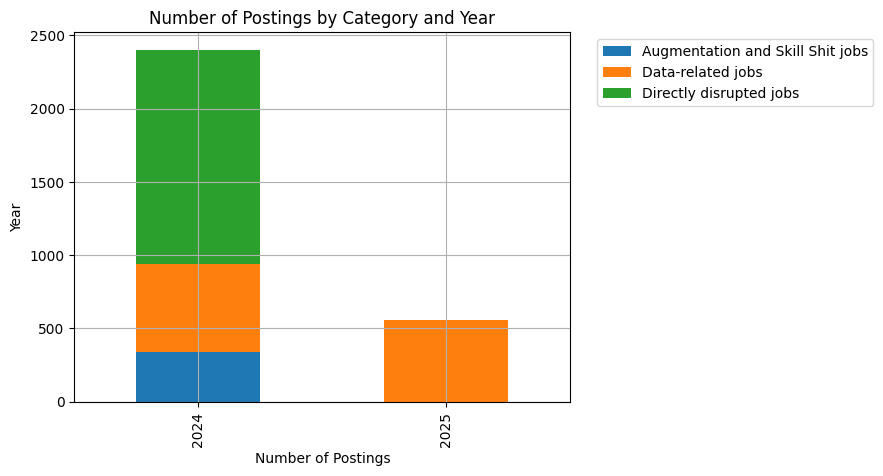

In [0]:
# change the df_merged to pandas df
df_merged = df_merged.toPandas()

# Pivot the data to have 'Product' as columns and 'Segment' as the index
pivot_df = df_merged.pivot(index='listed_year',
                    columns='posting_category',
                    values='num_postings')

# Create a grouped barplot
pivot_df.plot.bar(stacked=True,
                  grid=True)

# Add a legend
plt.legend(bbox_to_anchor=(1.04, 1), # shift the legend 4% on the right
           loc='upper left')

plt.xlabel('Number of Postings')
plt.ylabel('Year')
plt.title('Number of Postings by Category and Year')
plt.show()


# Stage: Visualisation
## Pie charts showing the number of postings within data-related jobs and disruptive jobs.

In [0]:
# import the 2024 data
# for each year, count the number 
df_2024_sub = spark.read.table('my_catalog.linkedin_postings_2023_25.sub_categorised_postings_23_24')
df_2025_sub = spark.read.table('my_catalog.linkedin_postings_2023_25.subcategories_25')

# merge the
display(df_2024_sub)
display(df_2025_sub)

# change the df to pandas df
df_2024_sub = df_2024_sub.toPandas()
df_2025_sub = df_2025_sub.toPandas()


category listed_year num_postings avg_cate_salary Accounting Clerk 2024 29 32838.107142857145 BI Analyst 2024 15 69774.85714285714 Bookkeeping 2024 2 null Customer Service 2024 1429 16927.68 Cybersecurity Analyst 2024 3 87500.0 Data Analyst 2024 216 49027.91453703703 Data Architect 2024 35 118076.94444444444 Data Engineer 2024 165 104989.25490196078 Data Scientist 2024 110 116203.25262500001 Database Administrator 2024 33 50061.88888888889 HR 2024 176 84855.55106382979 Inventory Manager 2024 3 null Lawyer 2024 25 120406.66666666667 Machine Learning Engineer 2024 23 148655.0 Other 2024 121445 78827.73694983593 Solicitor 2024 1 12401.404999999999 Supply Chain Manager 2024 16 121250.0 Underwriter 2024 120 99601.34166666667

category listed_year description Data Analyst 2025 The Social Measurement team is a growing team with high-visibility within the Communications organization that is being tasked with measuring the efficacy and impact of our social-first Communications and Marketing efforts. You'll play a unique role in shaping the way we approach reporting, define success, and leverage our own data to support the Communications team. In this role, you will employ data mining techniques to evaluate the success and efficacy of our social-first Communications and Marketing strategies. This role is also focused on social listening, where you'll be responsible for analyzing social conversation around specific topic areas. The ideal candidate will possess not only the technical proficiency to devise analytical solutions, but also have experience with data-storytelling.
 Data Analyst 2025 The Social Measurement team is a growing team with high-visibility within the Communications organization that is being tasked with measuring the efficacy and impact of our social-first Communications and Marketing efforts. You'll play a unique role in shaping the way we approach reporting, define success, and leverage our own data to support the Communications team. In this role, you will employ data mining techniques to evaluate the success and efficacy of our social-first Communications and Marketing strategies. This role is also focused on social listening, where you'll be responsible for analyzing social conversation around specific topic areas. The ideal candidate will possess not only the technical proficiency to devise analytical solutions, but also have experience with data-storytelling.
 Data Analyst 2025 The Social Measurement team is a growing team with high-visibility within the Communications organization that is being tasked with measuring the efficacy and impact of our social-first Communications and Marketing efforts. You'll play a unique role in shaping the way we approach reporting, define success, and leverage our own data to support the Communications team. In this role, you will employ data mining techniques to evaluate the success and efficacy of our social-first Communications and Marketing strategies. This role is also focused on social listening, where you'll be responsible for analyzing social conversation around specific topic areas. The ideal candidate will possess not only the technical proficiency to devise analytical solutions, but also have experience with data-storytelling.
 Data Analyst 2025 The Social Measurement team is a growing team with high-visibility within the Communications organization that is being tasked with measuring the efficacy and impact of our social-first Communications and Marketing efforts. You'll play a unique role in shaping the way we approach reporting, define success, and leverage our own data to support the Communications team. In this role, you will employ data mining techniques to evaluate the success and efficacy of our social-first Communications and Marketing strategies. This role is also focused on social listening, where you'll be responsible for analyzing social conversation around specific topic areas. The ideal candidate will possess not only the technical proficiency to devise analytical solutions, but also have experience with data-storytelling.
 Data Analyst 2025 About Pinterest
 Data Analyst 2025 About Fanduel
 Data Analyst 2025 Netflix is one of the world's leading entertainment services, with 283 million paid memberships in over 190 countries enjoying TV series, films and games across a wide variety of genres and languages. Members can play, pause and resume watching as much as they want, anytime, anywhere, and can change their plans at any time.
 Data Analyst 2025 About Fanduel
 Data Analyst 2025 Data Analyst (Ecommerce & Marketing Analytics)
 Data Analyst 2025 About Pinterest
 Data Analyst 2025 About Pinterest
 Data Analyst 2025 The Global Partnerships & Content organization at Meta work

In [0]:

df_2024_sub = df_2024_sub[df_2024_sub['category'] != 'Other']

# 2024 - throw the categories into three categories
# select the rows for data-related jobs
list_dt = df_2024_sub['category'].isin(['Data Scientist','Machine Learning Engineer', 
                                                   'Data Engineer', 'Data Architect',
                                                   'Data Analyst', 'BI Analyst',
                                                   'Data Administrator', 'Database Administrator', 'Cybersecurity Analyst'])

list_dis = ~df_2024_sub['category'].isin(['Data Scientist','Machine Learning Engineer', 
                                                   'Data Engineer', 'Data Architect',
                                                   'Data Analyst', 'BI Analyst',
                                                   'Data Administrator', 'Database Administrator', 'Cybersecurity Analyst'])


# data-related jobs - 2024
data_24 = df_2024_sub[list_dt]
print(data_24)

# disruption and augmentation and skill uplift jobs - 2024
dis_24 = df_2024_sub[list_dis]
print(dis_24)

# only data-related jobs - 2025
jobs_25 = df_2025_sub[df_2025_sub['category'] != 'Other']

# count the number of postings by job title
data_25 = jobs_25['category'].value_counts().reset_index()
print(data_25)



                     category  listed_year  num_postings  avg_cate_salary
1                  BI Analyst         2024            15     69774.857143
4       Cybersecurity Analyst         2024             3     87500.000000
5                Data Analyst         2024           216     49027.914537
6              Data Architect         2024            35    118076.944444
7               Data Engineer         2024           165    104989.254902
8              Data Scientist         2024           110    116203.252625
9      Database Administrator         2024            33     50061.888889
13  Machine Learning Engineer         2024            23    148655.000000
                category  listed_year  num_postings  avg_cate_salary
0       Accounting Clerk         2024            29     32838.107143
2            Bookkeeping         2024             2              NaN
3       Customer Service         2024          1429     16927.680000
10                    HR         2024           176     84

### Save the datasets for pie chart for dashboard.

In [0]:
# Define a list of tuples: (pandas_dataframe, target_table_name)
dataframes = [
    (data_24, 'data_24'),
    (dis_24, 'dis_24')
]

# Define the base catalog and schema path
base_table_path = 'my_catalog.da_profile_dt_dashboards.'

# Loop through each DataFrame and save as a Spark table
for pandas_df, table_name in dataframes:
    # Convert pandas DataFrame to Spark DataFrame
    spark_df = spark.createDataFrame(pandas_df)
    
    # Save to the specified table
    spark_df.write.mode('overwrite').saveAsTable(
        f'{base_table_path}{table_name}'
    )
    print(f"Saved {table_name} to Spark table successfully")
    

Saved data_24 to Spark table successfully
Saved dis_24 to Spark table successfully


In [0]:
print(data_24)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-7882702796832542>, line 1
----> 1 print(data_24)

NameError: name 'data_24' is not defined

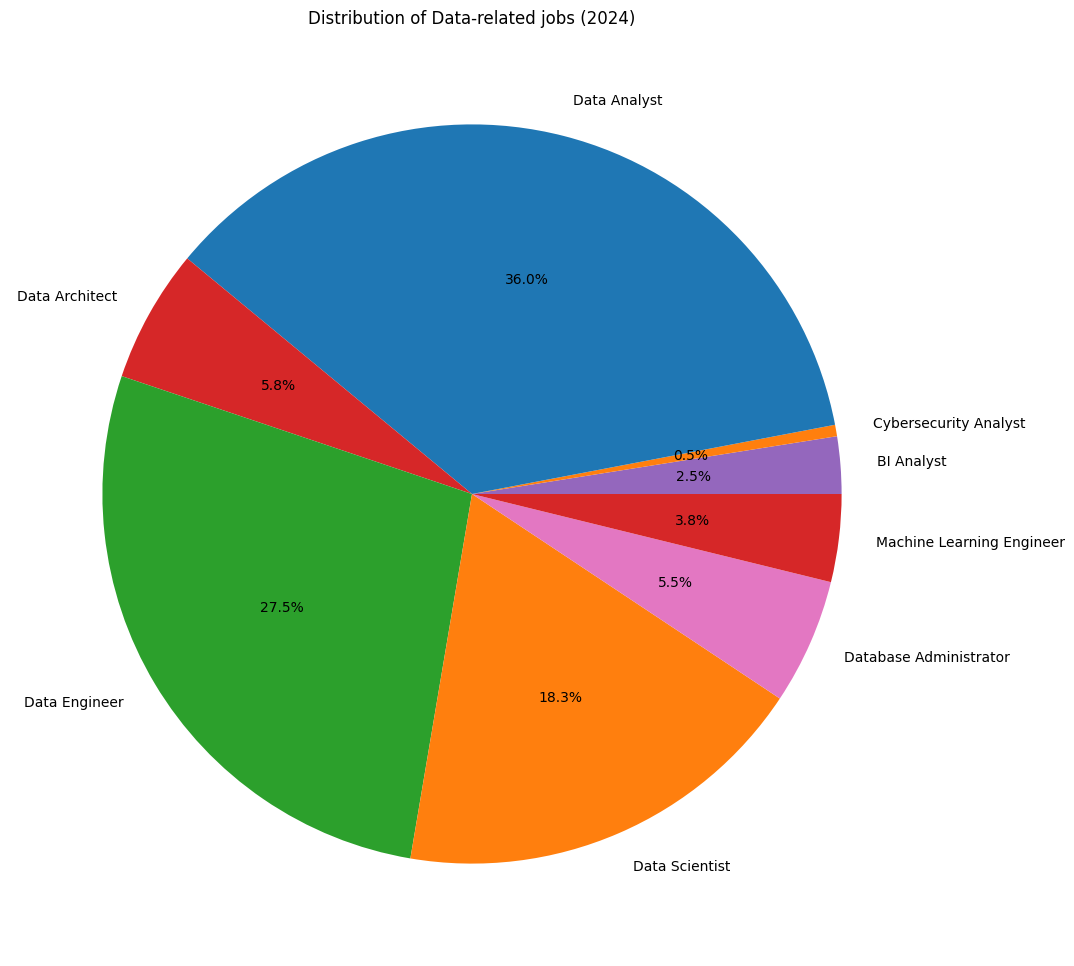

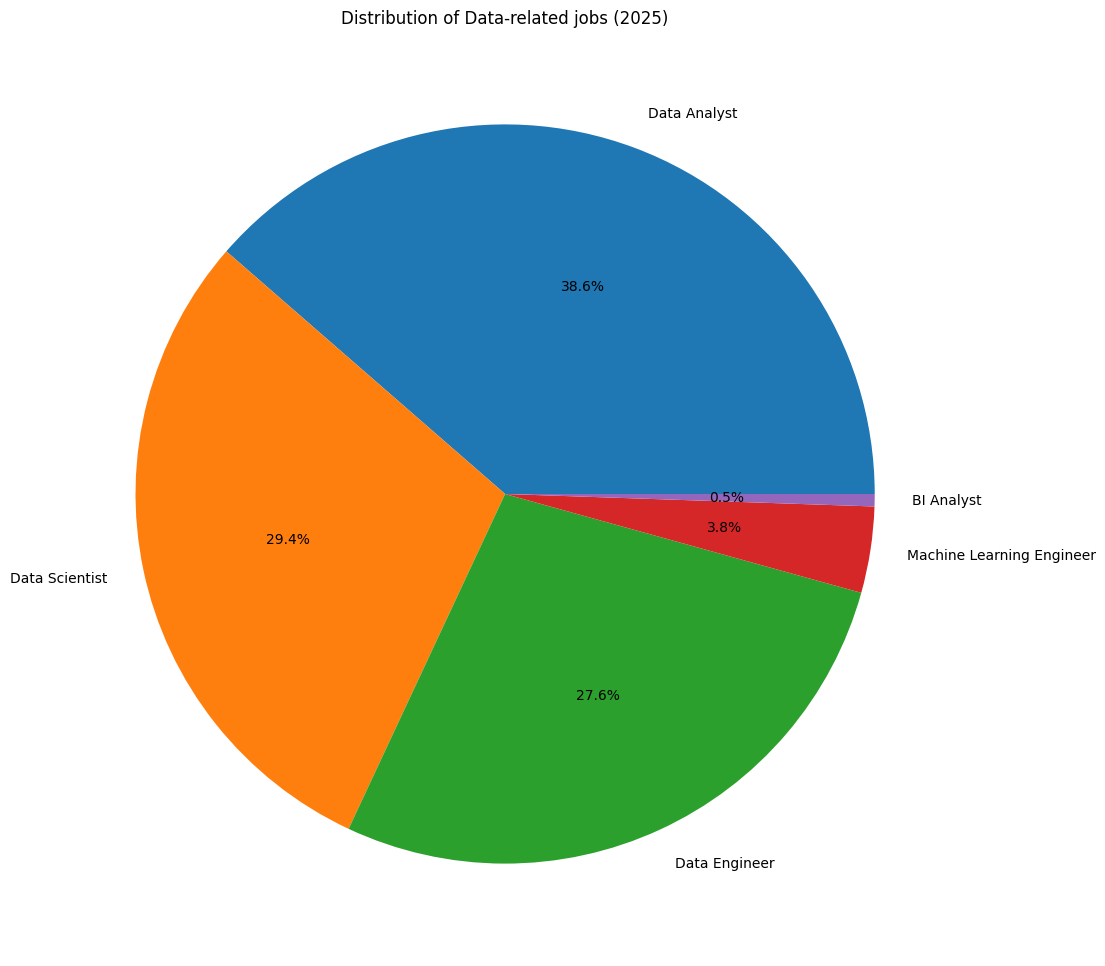

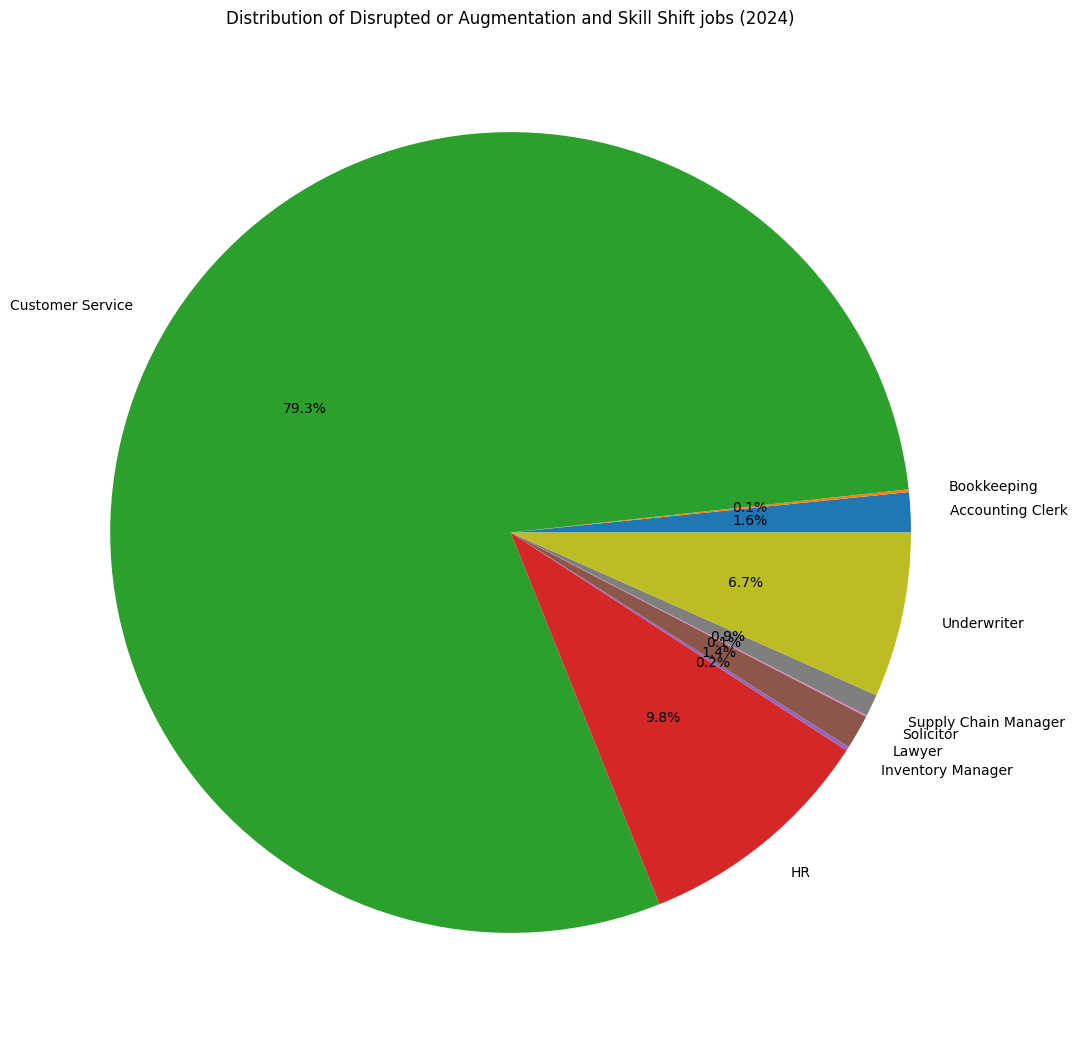

In [0]:
# Now produce three pie charts
# Create a color dictionary
custom_colors = {
    'Data Analyst': '#1f77b4',   # Blue
    'Data Scientist': '#ff7f0e', # Orange
    'Data Engineer': '#2ca02c',  # Green
    'Machine Learning Engineer': '#d62728', # Red
    'BI Analyst': '#9467bd'      # Purple
}

# Get default matplotlib colors (one for each category)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a final color list: use custom colors where defined, else defaults
final_colors = []
for i, cat in enumerate(data_24['category']):
    # Use custom color if available; else use the i-th default color
    final_colors.append(custom_colors.get(cat, default_colors[i % len(default_colors)]))

plt.figure(figsize=(12,12))
plt.pie(
   data_24['num_postings'], labels = data_24['category'],
    colors=final_colors, 
   autopct='%1.1f%%'
)

plt.title('Distribution of Data-related jobs (2024)')
plt.show()


# Extract colors in the order of `categories`
colors = [custom_colors[cat] for cat in data_25['index']]

plt.figure(figsize=(12,12))
plt.pie(
   data_25['category'], labels = data_25['index'], 
   colors=colors,
   autopct='%1.1f%%'
)

plt.title('Distribution of Data-related jobs (2025)')
plt.show()



plt.figure(figsize=(13,13))
plt.pie(
   dis_24['num_postings'], labels = dis_24['category'], 
   autopct='%1.1f%%'
)

plt.title('Distribution of Disrupted or Augmentation and Skill Shift jobs (2024)')
plt.show()



# Stage Visualisation
### A word cloud chart for skills required in data-related jobs.

In [0]:
# install the package
%pip install wordcloud

# import the package
from wordcloud import WordCloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 100.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wordcloud: filename=wordcloud-1.9.4-cp312-cp312-linux_aarch64.whl size=469587 sha256=4a94d41e1721000deeddda7acd871ffcbe68b396ba139a3b8c059a57fa610370
  Stored in directory: /home/spark-7f53ae95-35b5-443c-bb07-b6/.cache/pip/wheels/93/2a/62/2b71344178dc0164dcf96a0449d00886229f8e050ffa76a010
Successfully built wordcloud
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# import the cleaned counts data
software_counts = spark.read.table("my_catalog.linkedin_postings_2023_25.software_counts")
softskill_counts = spark.read.table("my_catalog.linkedin_postings_2023_25.soft_skill_counts")
database_counts = spark.read.table ("my_catalog.linkedin_postings_2023_25.database_counts")

# covert each to pandas dataframe
software_counts = software_counts.toPandas()
softskill_counts = softskill_counts.toPandas()
database_counts = database_counts.toPandas()

#display
print(software_counts)
print(softskill_counts)
print(database_counts)


          Software  count
0              SQL    665
1           Python    352
2              AWS    227
3            Azure    154
4              Git     28
5              GCP     26
6       Javascript      4
7  Cloud Platforms      1
           Soft_Skills  count
0        communication    224
1      problem-solving     96
2  analytical thinking      7
3         adaptability      1
       Databases  count
0         Oracle     46
1        MongoDB     22
2     PostgreSQL     21
3          MySQL     17
4  Microsoft SQL     13
5          Redis      4


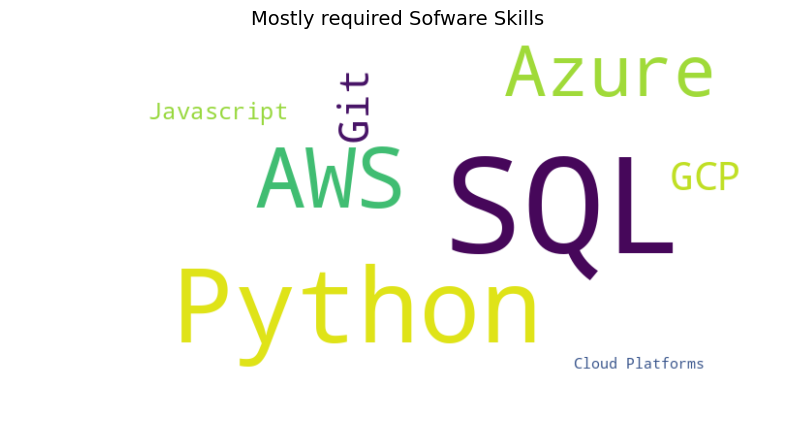

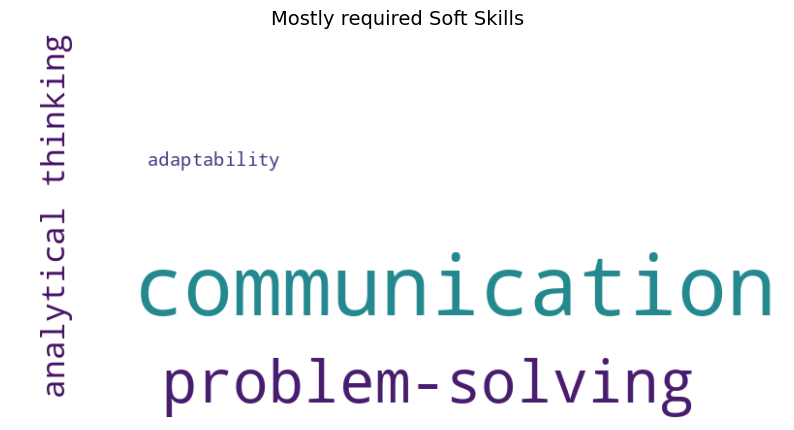

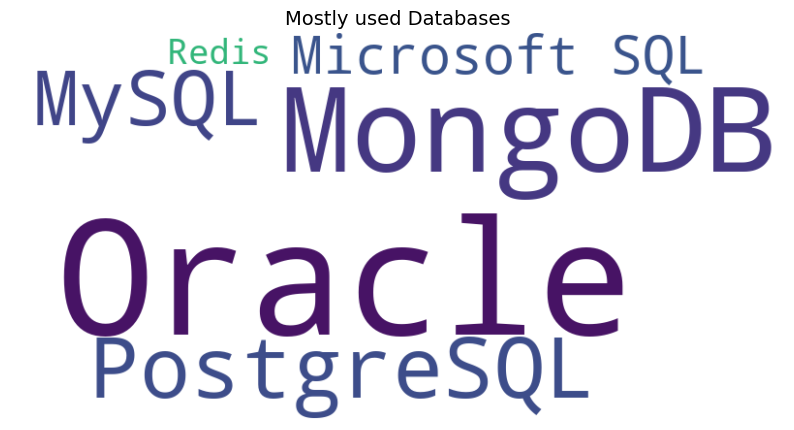

In [0]:
# lower max_font_size, change the maximum number of word and lighten the background:
# List of tuples: (DataFrame, chart_title)
dataframes = [
    (software_counts, 'Mostly required Sofware Skills','Software'),
    (softskill_counts, 'Mostly required Soft Skills', 'Soft_Skills'),
    (database_counts, 'Mostly used Databases', 'Databases')
]

# Loop through each DataFrame in the list
for df, title, word_col in dataframes:
    # Create frequency dictionary from the DataFrame
    word_freq = df.set_index(word_col)['count'].to_dict()
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white'
    ).generate_from_frequencies(word_freq)
    
    # Plot and display
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the plot
    

# Stage:Visualisation
### A bar chart showing the average annual salary for each data-related job category.


In [0]:
# Load the table
df = spark.read.table("my_catalog.linkedin_postings_2023_25.data_postings_23_views_applies")

# Convert to pandas DataFrame
df_pd = df.toPandas()


In [0]:
# Categorise data-related jobs into broader categories
df_pd = df_pd[df_pd['category'] != 'Other']

# Define exact job title to category mapping
job_category_map = {
    # Data Infrastructure
    'Data Engineer': 'Data Infrastructure',
    'Data Architect': 'Data Infrastructure',
    
    # Data Analysis
    'Data Analyst': 'Data Analysis', 
    'BI Analyst': 'Data Analysis',
    
    # Data Science and AI
    'Data Scientist': 'Data Science and AI',
    'Machine Learning Engineer': 'Data Science and AI',
    
    # Data Management and Security
    'Data Administrator': 'Data Management and Security',
    'Database Administrator': 'Data Management and Security',
    'Cybersecurity Analyst': 'Data Management and Security'
}

# Apply the mapping
df_pd['broad_category'] = df_pd['category'].map(job_category_map)

# Fill any unmatched jobs with 'Other'
df_pd['broad_category'] = df_pd['broad_category'].fillna(df_pd['category'])

df_pd.head(10)

category  listed_year  ...  pay_period       broad_category
0  Customer Service         2024  ...        None     Customer Service
1  Customer Service         2024  ...      HOURLY     Customer Service
2  Customer Service         2024  ...        None     Customer Service
3  Customer Service         2024  ...      YEARLY     Customer Service
4    Data Architect         2024  ...        None  Data Infrastructure
5                HR         2024  ...      YEARLY                   HR
6       Underwriter         2024  ...      HOURLY          Underwriter
7     Data Engineer         2024  ...        None  Data Infrastructure
8            Lawyer         2024  ...      HOURLY               Lawyer
9      Data Analyst         2024  ...        None        Data Analysis

[10 rows x 8 columns]

In [0]:
# change all the salaries to annual
df_pd['avg_salary'] = df_pd['avg_salary'] * df_pd['pay_period'].map({'YEARLY': 1, 'MONTHLY': 12, 'WEEKLY': 52, 'HOURLY': 2080})

# keep only entry-level and associate level salaries
df_pd_entry = df_pd[df_pd['formatted_experience_level'].isin(['Entry level', 'Associate'])] 
df_pd_entry.describe()

listed_year        views     applies     avg_salary
count        860.0   844.000000  214.000000     189.000000
mean        2024.0    24.142180   24.658879   69555.904206
std            0.0    85.691292   46.833743   44449.234451
min         2024.0     1.000000    1.000000      19.500000
25%         2024.0     3.000000    1.000000   39520.000000
50%         2024.0     4.000000    5.000000   54750.000000
75%         2024.0     8.000000   24.750000   91875.000000
max         2024.0  1393.000000  339.000000  301600.000000

In [0]:
# keep mid-senior level
df_pd_mid = df_pd[df_pd['formatted_experience_level'] == 'Mid-Senior level']
# drop outliers
df_pd_mid = df_pd[df_pd['avg_salary'] < 1000000]
df_pd_mid.describe()

listed_year        views     applies     avg_salary
count        528.0   518.000000  203.000000     528.000000
mean        2024.0    45.658301   31.916256   85576.344186
std            0.0   167.719120   60.698719   53469.252547
min         2024.0     1.000000    1.000000      19.500000
25%         2024.0     3.000000    2.000000   42640.000000
50%         2024.0     5.000000    6.000000   70000.000000
75%         2024.0    17.750000   27.000000  119950.000000
max         2024.0  2249.000000  339.000000  317200.000000

In [0]:
# find the mean of entry-level salaries
mean_df_entry = df_pd_entry.groupby('broad_category')['avg_salary'].agg(['mean','count']).reset_index()
mean_df_entry.columns = ['broad_category', 'mean_salary','count']
print(mean_df_entry)

# find the mean mid-senior level salaries
mean_df_mid = df_pd_mid.groupby('broad_category')['avg_salary'].agg(['mean','count']).reset_index()
mean_df_mid.columns = ['broad_category', 'mean_salary', 'count']
print(mean_df_mid)

                  broad_category    mean_salary  count
0               Accounting Clerk   46157.461538     13
1                    Bookkeeping            NaN      0
2               Customer Service   41443.848859     92
3                  Data Analysis   82314.537037     27
4            Data Infrastructure  130232.000000     12
5   Data Management and Security   71265.000000      4
6            Data Science and AI  134879.327778     18
7                             HR   84251.026667     15
8              Inventory Manager            NaN      0
9                         Lawyer  206366.666667      3
10                   Underwriter   70431.000000      5
                  broad_category    mean_salary  count
0               Accounting Clerk   45683.357143     14
1               Customer Service   46373.951772    237
2                  Data Analysis   96410.029508     61
3            Data Infrastructure  138697.635593     59
4   Data Management and Security  110250.550000     10
5         

In [0]:
# for consistency, keep the same postings for salaries in entry and mid-senior level
mean_df_entry = mean_df_entry[mean_df_entry['broad_category'] != 'Lawyer']
mean_df_mid = mean_df_mid[mean_df_mid['broad_category'].isin(['Accounting Clerk','Bookkeeping','Customer Service','Data Analysis', 'Data Infrastructure','Data Management and Security',
                                                            'Data Science and AI','HR', 'Underwriter'])]

/home/spark-6461879b-34a6-41cf-ae0b-32/.ipykernel/4062/command-4732298300980012-1472856172:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


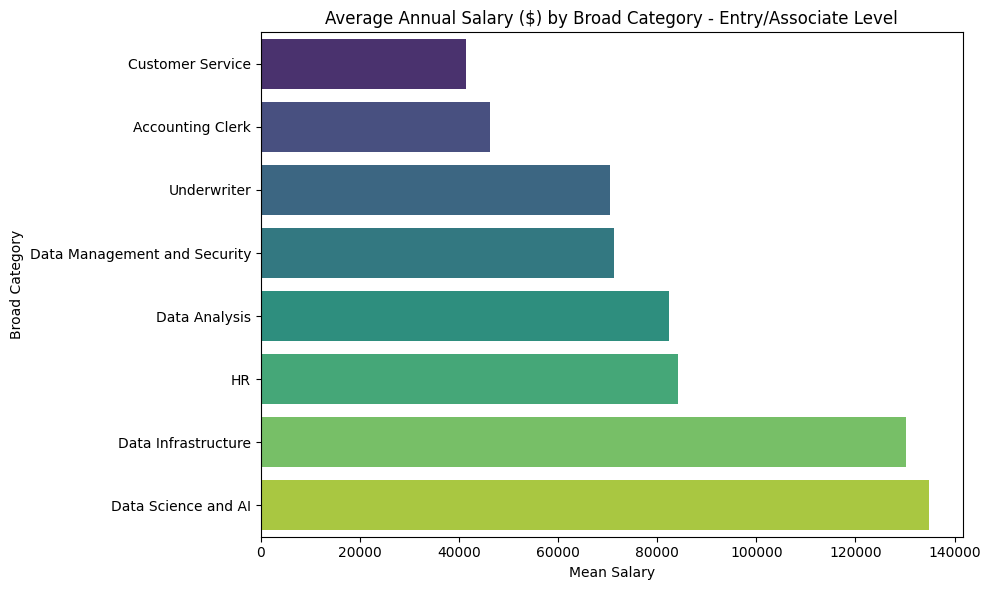

/home/spark-6461879b-34a6-41cf-ae0b-32/.ipykernel/4062/command-4732298300980012-1472856172:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


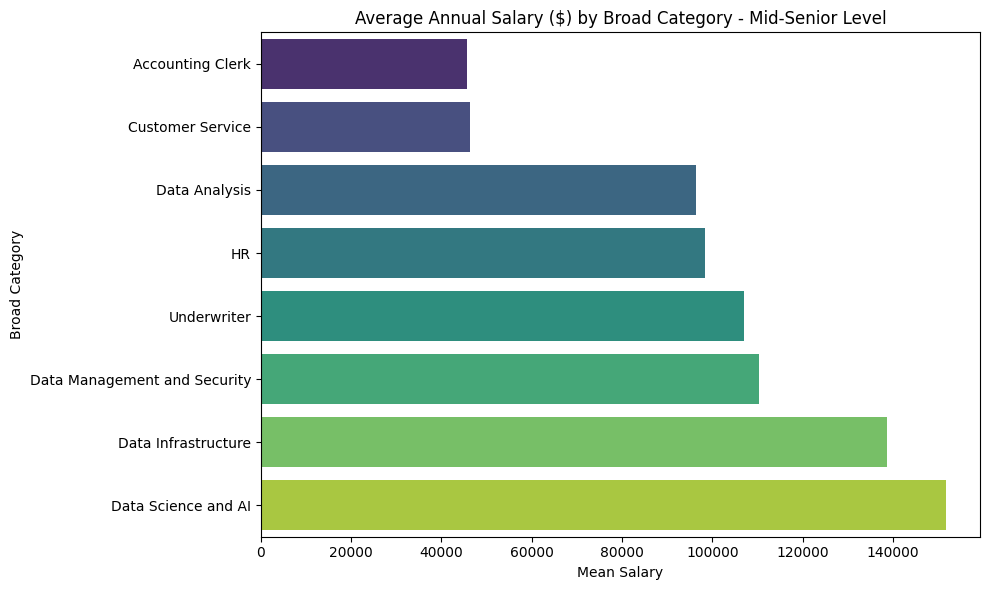

In [0]:
for mean_df, level in zip([mean_df_entry, mean_df_mid], ['Entry/Associate', 'Mid-Senior']):
    # sort the order of the bars
    mean_df_sorted = mean_df[mean_df['mean_salary'] > 0].sort_values('mean_salary', ascending=True)
    
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=mean_df_sorted,
        x='mean_salary',
        y='broad_category',
        palette='viridis'
    )
    plt.title(f"Average Annual Salary ($) by Broad Category - {level} Level")
    plt.xlabel("Mean Salary")
    plt.ylabel("Broad Category")
    plt.tight_layout()
    plt.show()

### Save the salary data for dashboard.

In [0]:
for df, name in zip([mean_df_entry, mean_df_mid], ['mean_df_entry', 'mean_df_mid']):
    spark_df = spark.createDataFrame(df)
    spark_df.write.mode('overwrite').saveAsTable(
        f'my_catalog.da_profile_dt_dashboards.{name}'
    )

# Stage: Visualisation
## Correlation between views or applies and salary for each experience level


In [0]:
# drp avg_salary below 50000 as these are not monthly salaries
df_pd = df_pd[df_pd["avg_salary"] >= 30000]

counts =  df_pd.groupby("pay_period").size()
print(counts)

pay_period
YEARLY    119
dtype: int64


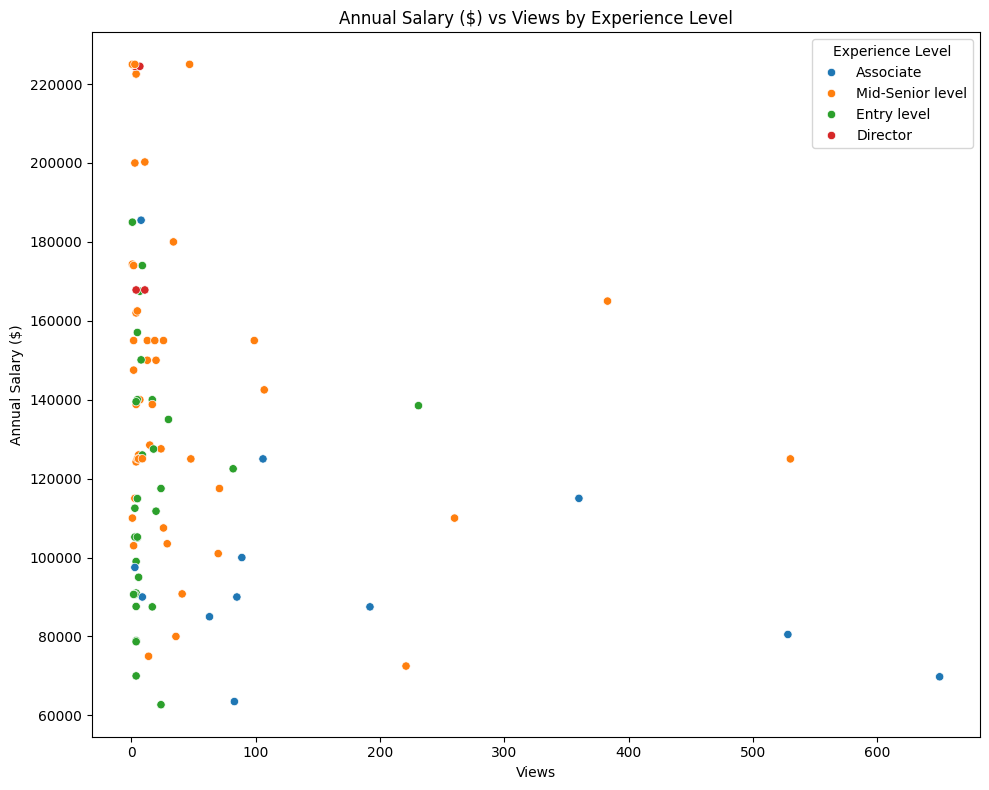

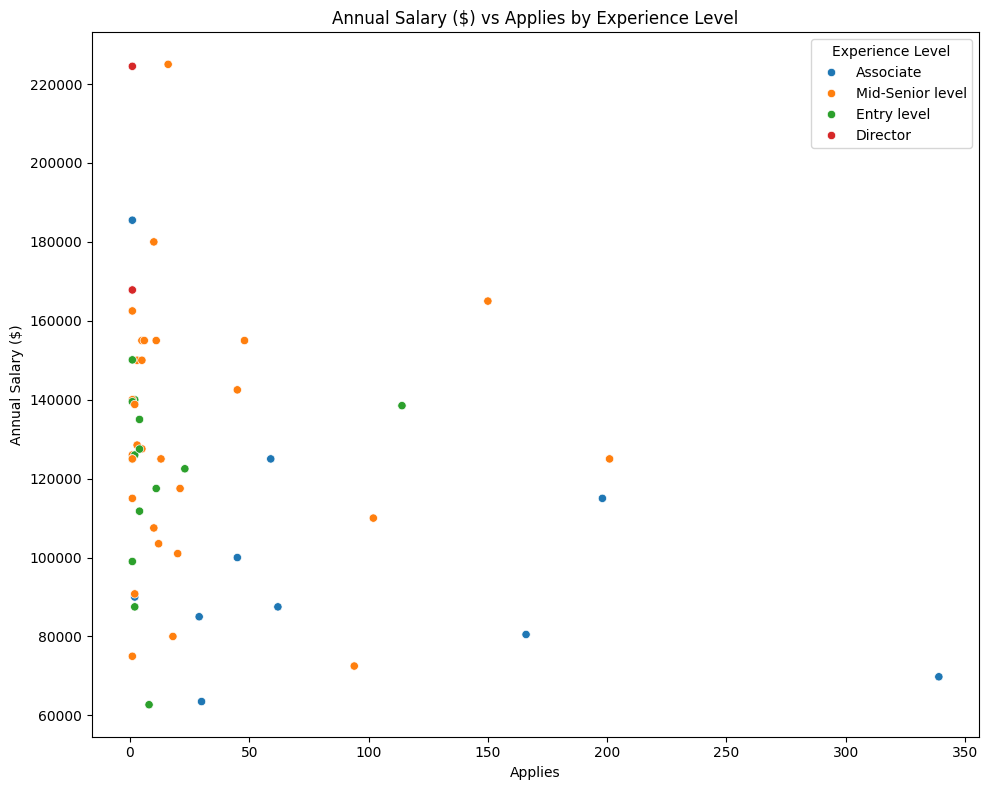

In [0]:
# Plot scatter plot
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=df_pd,
    x="views",
    y="avg_salary",
    hue = 'formatted_experience_level'
   
)
plt.title("Annual Salary ($) vs Views by Experience Level")
plt.xlabel("Views")
plt.ylabel("Annual Salary ($)")
plt.legend(title="Experience Level")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(
    data=df_pd,
    x="applies",
    y="avg_salary",
    hue = 'formatted_experience_level'
   
)
plt.title("Annual Salary ($) vs Applies by Experience Level")
plt.xlabel("Applies")
plt.ylabel("Annual Salary ($)")
plt.legend(title="Experience Level")
plt.tight_layout()
plt.show()
